In [1]:
import numpy as np

In [8]:
np.linspace(80, 120, 8 + 1)

array([ 80.,  85.,  90.,  95., 100., 105., 110., 115., 120.])

In [15]:
np.linspace(50, 150, 50+1)

array([ 50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,  66.,  68.,  70.,
        72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,  88.,  90.,  92.,
        94.,  96.,  98., 100., 102., 104., 106., 108., 110., 112., 114.,
       116., 118., 120., 122., 124., 126., 128., 130., 132., 134., 136.,
       138., 140., 142., 144., 146., 148., 150.])

In [16]:
import multiprocessing
from concurrent.futures import ThreadPoolExecutor, as_completed

In [17]:
n_cpu_cores = multiprocessing.cpu_count()  # get the number of CPU cores
max_threads_cpu_task = n_cpu_cores - 2  # leave 2 cores free for other tasks

In [18]:
max_threads_cpu_task

18

In [12]:
from itertools import product

In [21]:
Option_types=["call", "put"]  # call, put
S_values=list(np.linspace(50, 150, 50 + 1))  # 50, 52, 54, ..., 150
K_values=[100]  # 100
T_values=[
    0.08,
    0.25,
    0.5,
    1.0,
    1.5,
    2.0,
    2.5,
    3.0,
    4.0,
    5.0,
]  # 1 month, 3 months, 6 months, 1 year, 1.5 years, 2 years, 2.5 years, 3 years, 4 years, 5 years
r_values=[0.01, 0.025, 0.05, 0.075, 0.1]  # 1%, 2.5%, 5%, 7.5%, 10%
sigma_values=[0.1, 0.2, 0.4, 0.6, 0.8]
q_values=[0.0, 0.01, 0.02, 0.03, 0.04, 0.05]

In [30]:
from typing import Literal
import numpy as np
import pandas as pd


def mc_price_worst_off(
    option_type: Literal["call", "put"],
    S1: float,
    S2: float,
    K1: float,
    K2: float,
    sigma1: float,
    sigma2: float,
    q1: float = 0.0,
    q2: float = 0.0,
    corr: float = 0.0,
    T: float = 1.0,
    r: float = 0.05,
    n_paths: int = 10000,  # number of paths to simulate, to make error 1/sqrt(n_paths) = 0.01 or 1%
) -> float:
    dt = T
    drift1 = dt * (r - q1 - 0.5 * sigma1**2)
    diffusion1 = sigma1 * np.sqrt(dt)

    Z1 = np.random.standard_normal(n_paths)
    ST1 = S1 * np.exp(drift1 + diffusion1 * Z1)

    dt = T
    drift2 = dt * (r - q2 - 0.5 * sigma2**2)
    diffusion2 = sigma2 * np.sqrt(dt)

    Z2 = np.random.standard_normal(n_paths)
    ST2 = S2 * np.exp(drift2 + diffusion2 * (corr * Z1 + np.sqrt(1 - corr**2) * Z2))

    if option_type == "call":
        # Confusion with what said in the word document in the email
        # performance_of_first = np.maximum(ST1/S1, 0.0)
        # performance_of_second = np.maximum(ST2/S2, 0.0)

        performance_of_first = np.maximum(ST1 - K1, 0.0)
        performance_of_second = np.maximum(ST2 - K2, 0.0)
        payoffs = np.minimum(performance_of_first, performance_of_second)
    else:
        performance_of_first = np.maximum(K1 - ST1, 0.0)
        performance_of_second = np.maximum(K2 - ST2, 0.0)
        payoffs = np.minimum(performance_of_first, performance_of_second)

    res = {
        "S1" : [S1]*10000,
        "ST1" : ST1,
        "P1" : performance_of_first,
        "S2" : [S2]*10000,
        "ST2" : ST2,
        "P2" : performance_of_second,
        "payoff" : payoffs
    }
    res = pd.DataFrame(res)
    
    print("shape of worst off", payoffs.shape)
    price = np.exp(-r * T) * payoffs.mean()  # discount factor for risk-free rate
    return price, res

In [33]:
price , res = mc_price_worst_off(
    "call",
    np.float64(100.0),
    np.float64(100.0),
    100,
    100,
    0.1,
    0.1,
    0.01,
    0.01,
    0.01,
    0.08,
    0.01,
)

shape of worst off (10000,)


In [35]:
res

,S1,ST1,P1,S2,ST2,P2,payoff
0,100.0,99.814481,0.000000,100.0,100.714262,0.714262,0.000000
1,100.0,105.041496,5.041496,100.0,97.827702,0.000000,0.000000
2,100.0,96.860109,0.000000,100.0,97.875926,0.000000,0.000000
3,100.0,98.561025,0.000000,100.0,101.670757,1.670757,0.000000
4,100.0,100.396476,0.396476,100.0,103.009539,3.009539,0.396476
...,...,...,...,...,...,...,...
9995,100.0,97.154849,0.000000,100.0,104.969948,4.969948,0.000000
9996,100.0,97.378225,0.000000,100.0,100.854286,0.854286,0.000000
9997,100.0,101.107652,1.107652,100.0,103.615702,3.615702,1.107652
9998,100.0,100.545155,0.545155,100.0,98.496259,0.000000,0.000000


In [20]:
Option_types=["call", "put"]
S1_values=list(np.linspace(80, 120, 8 + 1))
S2_values=list(np.linspace(80, 120, 8 + 1))
K1_values=[100]
K2_values=[100]
sigma1_values=[0.1, 0.4, 0.8]
sigma2_values=[0.1, 0.4, 0.8]
q1_values=[0.01, 0.02, 0.05]
q2_values=[0.01, 0.02, 0.05]
corr_values=[0.01, 0.2, 0.5, 0.8]
T_values=[0.08, 0.5, 1.0, 2.0, 5.0]
r_values = [0.01, 0.025, 0.05, 0.1]

In [22]:
for _ in product(
        Option_types,
        S1_values,
        S2_values,
        K1_values,
        K2_values,
        sigma1_values,
        sigma2_values,
        q1_values,
        q2_values,
        corr_values,
        T_values,
        r_values,
    ):
    print(_)
    break

('call', np.float64(80.0), np.float64(80.0), 100, 100, 0.1, 0.1, 0.01, 0.01, 0.01, 0.08, 0.01)


In [21]:
n = sum(
    1
    for _ in product(
        Option_types,
        S1_values,
        S2_values,
        K1_values,
        K2_values,
        sigma1_values,
        sigma2_values,
        q1_values,
        q2_values,
        corr_values,
        T_values,
        r_values,
    )
)
print("Number of combinations:", n)

Number of combinations: 1049760


In [23]:
import math

lengths = [
    len(Option_types),
    len(S_values),
    len(K_values),
    len(T_values),
    len(r_values),
    len(sigma_values),
    len(q_values),
]

n_combinations = math.prod(lengths)
print("Number of combinations:", n_combinations)

Number of combinations: 153000


In [43]:
(len(out_features) * 1000000 * 8) / (1024 * 1024 * 1024)

5.81890344619751

In [24]:
lengths

[2, 51, 1, 10, 5, 5, 6]

In [1]:
import pandas as pd

In [2]:
training_data = pd.read_csv("../_data/03_splitted/Worst_Off/training_data.csv")
test_data = pd.read_csv("../_data/03_splitted/Worst_Off/testing_data.csv")

In [17]:
from sklearn.decomposition import PCA

In [4]:
test_data.iloc[:,1:-1]

,stock_price_1,stock_price_2,strike_price_1,strike_price_2,volatility_1,volatility_2,dividend_yield_1,dividend_yield_2,correlation,time_to_maturity,...,dividend_yield_1_over_volatility_1_times_interest_rate_over_volatility_2,dividend_yield_1_over_volatility_1_times_dividend_yield_2_over_volatility_2,dividend_yield_1_over_volatility_1_times_stock_price_2_over_volatility_2,stock_price_1_over_volatility_1_times_interest_rate_over_volatility_2,stock_price_1_over_volatility_1_times_dividend_yield_2_over_volatility_2,stock_price_1_over_volatility_1_times_stock_price_2_over_volatility_2,interest_rate_over_volatility_2_times_dividend_yield_2_over_volatility_2,interest_rate_over_volatility_2_times_stock_price_2_over_volatility_2,dividend_yield_2_over_volatility_2_times_stock_price_2_over_volatility_2,option_type_put
0,-1.556005,1.164066,0.0,0.0,-1.165287,1.278237,-0.980097,1.368843,-0.598207,1.867393,...,-0.379935,-0.265298,-0.415199,-0.390407,-0.060857,-0.316310,-0.444847,-0.554652,-0.550861,0.0
1,0.775005,-1.159845,0.0,0.0,-0.120607,1.278237,-0.391231,-0.982997,-0.598207,-0.688684,...,-0.406285,-0.438181,-0.506845,-0.479817,-0.524328,-0.604610,-0.461200,-0.558680,-0.599365,0.0
2,1.552008,-1.159845,0.0,0.0,1.272299,1.278237,-0.980097,-0.982997,-0.598207,-0.927251,...,-0.429999,-0.452587,-0.547138,-0.516432,-0.539881,-0.649246,-0.463653,-0.565527,-0.599365,0.0
3,-0.390500,1.164066,0.0,0.0,-1.165287,-1.163880,-0.980097,1.368843,-1.230428,1.867393,...,-0.263996,1.079341,0.602396,-0.008927,4.169486,2.968937,0.058011,-0.174821,3.034973,1.0
4,0.775005,-0.772527,0.0,0.0,-0.120607,-0.117258,1.375366,-0.982997,-0.598207,0.163342,...,-0.169136,-0.361344,-0.276148,-0.339316,-0.490112,-0.494856,-0.432582,-0.473423,-0.572143,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31488,1.163507,0.002110,0.0,0.0,-1.165287,-0.117258,-0.391231,1.368843,1.398279,0.163342,...,-0.221836,0.310976,-0.054932,-0.134952,0.872307,0.263439,-0.383523,-0.516387,-0.409803,1.0
31489,-1.167504,1.551385,0.0,0.0,-1.165287,1.278237,-0.980097,1.368843,1.398279,-0.404675,...,-0.221836,-0.265298,-0.408878,0.052382,-0.029752,-0.274299,-0.383523,-0.505646,-0.548386,0.0
31490,0.775005,-0.385208,0.0,0.0,-1.165287,-0.117258,-0.980097,-0.982997,0.400036,0.163342,...,-0.011037,-0.380553,-0.320392,0.972021,-0.284816,0.175216,-0.399876,-0.366012,-0.570164,0.0
31491,0.386503,-1.159845,0.0,0.0,-1.165287,-0.117258,-0.391231,-0.982997,0.400036,-0.927251,...,-0.348315,-0.303717,-0.130778,-0.383595,-0.297259,0.047083,-0.458747,-0.551832,-0.574123,1.0


In [5]:
X_train = training_data.iloc[:, 1:-1]
y_train = training_data.iloc[:, -1]
X_test = test_data.iloc[:, 1:-1]
y_test = test_data.iloc[:, -1]

In [46]:
res = pd.read_csv('../results/European_Vanilla/model_comparison.csv')

In [47]:
res

,family,model,data_mode,train_rmse,test_rmse,time_s,best_estimator
0,linear_models,LinearRegression,all_variables,14.725865,14.795904,2.774921,LinearRegression()
1,linear_models,LinearRegression,top_vars,15.225467,15.305413,1.239335,LinearRegression()
2,linear_models,LinearRegression,pca,15.589834,15.636886,1.200742,LinearRegression()
3,linear_models,LinearRegression,autoencoder,14.885668,14.928377,0.997752,LinearRegression()
4,linear_models,Ridge,all_variables,14.727014,14.792768,0.688798,Ridge(alpha=10.0)
5,linear_models,Ridge,top_vars,15.225486,15.305207,0.277543,Ridge(alpha=0.1)
6,linear_models,Ridge,pca,15.589834,15.636885,0.226269,Ridge(alpha=10.0)
7,linear_models,Ridge,autoencoder,14.787642,14.829182,0.212011,Ridge()
8,tree_models,RandomForestRegressor,all_variables,9.820278,10.198507,10.752510,"RandomForestRegressor(max_depth=20, max_featur..."
9,tree_models,RandomForestRegressor,top_vars,14.864711,15.207993,9.365680,"RandomForestRegressor(max_depth=10, max_featur..."


In [67]:
res.groupby("data_mode")["test_rmse"].min()

data_mode
all_variables     0.449164
autoencoder       0.463614
pca              14.977880
top_vars         15.042820
Name: test_rmse, dtype: float64

In [19]:
type(X_train)

pandas.core.frame.DataFrame

In [20]:
type(X_test)

pandas.core.frame.DataFrame

In [12]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [91]:
class AutoencoderFeatureExtractor(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoencoderFeatureExtractor, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, encoding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def extract_features(self, x):
        with torch.no_grad():
            return self.encoder(x)

In [94]:
# Training function
def train_autoencoder(
    option_type, model, x_train, device, epochs=25, batch_size=64, learning_rate=1e-4
):
    model_path = f"results/{option_type}/autoencoder_model.pth"

    # Check if the model already exists
    if os.path.exists(model_path):
        print(f"Model already exists at {model_path}. Loading the model.")
        model.load_state_dict(torch.load(model_path))
        return model

    # Move model to GPU if available
    model = model.to(device)

    print("Training the autoencoder...")
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Move data to GPU if available
    x_train = x_train.to(device)

    dataset = torch.utils.data.TensorDataset(x_train, x_train)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True
    )

    for epoch in range(epochs):
        for batch in dataloader:
            inputs, _ = batch
            inputs = inputs.to(device)  # Move inputs to GPU

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    # Save the trained model
    os.makedirs(f"results/{option_type}", exist_ok=True)
    torch.save(model.state_dict(), model_path)
    print(f"Model saved at {model_path}")

    return model

In [93]:
# Example usage
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
    
input_dim = X_train.shape[1]
encoding_dim = 40
model = AutoencoderFeatureExtractor(input_dim, encoding_dim)
X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float32)
model = train_autoencoder("Worst_Off", model, X_train_tensor, device)


Using device: cuda
Training the autoencoder...
Epoch [1/250], Loss: 0.0676
Epoch [2/250], Loss: 0.0447
Epoch [3/250], Loss: 0.0353
Epoch [4/250], Loss: 0.0194
Epoch [5/250], Loss: 0.0211
Epoch [6/250], Loss: 0.0180
Epoch [7/250], Loss: 0.0152
Epoch [8/250], Loss: 0.0115
Epoch [9/250], Loss: 0.0106
Epoch [10/250], Loss: 0.0097
Epoch [11/250], Loss: 0.0135
Epoch [12/250], Loss: 0.0106
Epoch [13/250], Loss: 0.0094
Epoch [14/250], Loss: 0.0071
Epoch [15/250], Loss: 0.0083
Epoch [16/250], Loss: 0.0092
Epoch [17/250], Loss: 0.0082
Epoch [18/250], Loss: 0.0077
Epoch [19/250], Loss: 0.0075
Epoch [20/250], Loss: 0.0067
Epoch [21/250], Loss: 0.0076
Epoch [22/250], Loss: 0.0068
Epoch [23/250], Loss: 0.0066
Epoch [24/250], Loss: 0.0056
Epoch [25/250], Loss: 0.0058
Epoch [26/250], Loss: 0.0052


KeyboardInterrupt: 

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [76]:
x = model.forward(
    torch.tensor(X_test.to_numpy(), dtype=torch.float32).to(device)
).cpu().detach().numpy()

In [77]:
np.mean((X_test - x)**2)

np.float64(0.0056699612002510755)

In [ ]:
X_train_features = (
    model.extract_features(X_train_tensor.to(device)).cpu().detach().numpy()
)
X_test_tensor = torch.tensor(np.array(X_test), dtype=torch.float32)
X_test_features = (
    model.extract_features(X_test_tensor.to(device)).cpu().detach().numpy()
)

In [43]:
X_test_features.shape

(31493, 40)

In [44]:
X_test.shape

(31493, 782)

In [ ]:
# Training function
def train_autoencoder(
    option_type, model, x_train, epochs=50, batch_size=32, learning_rate=0.001
):
    model_path = f"results/{option_type}/autoencoder_model.pth"

    # Check if the model already exists
    if os.path.exists(model_path):
        print(f"Model already exists at {model_path}. Loading the model.")
        model.load_state_dict(torch.load(model_path))
        return model

    print("Training the autoencoder...")
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    dataset = torch.utils.data.TensorDataset(x_train, x_train)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True
    )

    for epoch in range(epochs):
        for batch in dataloader:
            inputs, _ = batch
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    # Save the trained model
    os.makedirs(f"results/{option_type}", exist_ok=True)
    torch.save(model.state_dict(), model_path)
    print(f"Model saved at {model_path}")

    return model

In [19]:
y_train

0         0.0000
1        37.9436
2         0.0548
3         8.3174
4         2.6999
          ...   
73478     0.0307
73479     2.7448
73480     5.2139
73481    19.5519
73482     3.3569
Name: price, Length: 73483, dtype: float64

In [ ]:
df = pd.read_csv("../data/02_processed/Worst_Off_processed_dataset.csv")

In [ ]:
df

In [22]:
corr = df.corr()

In [26]:
x = corr["price"].sort_values(ascending=False)

In [28]:
x[x>0.1]

price                                               1.000000
volatility_2_times_log1p_T                          0.510986
volatility_1_times_log1p_T                          0.510255
volatility_2_times_sqrt_T                           0.509130
volatility_1_times_sqrt_T                           0.508229
                                                      ...   
interest_rate_times_volatility_2_over_dividend_2    0.111578
volatility_2_times_interest_rate_over_dividend_1    0.110532
volatility_1_times_interest_rate_over_dividend_1    0.108626
interest_rate_times_volatility_1_over_dividend_1    0.108626
volatility_1_times_interest_rate_over_dividend_2    0.107971
Name: price, Length: 347, dtype: float64

In [29]:
pca_full = PCA(random_state=2025)
pca_full.fit(df.drop(columns='price'))

PCA(random_state=2025)

In [9]:
import numpy as np

In [30]:
print("Model Trainer: ", "PCA for full dataset calculated")

# Adding the amount of variance explained by each component
cum_var = np.cumsum(pca_full.explained_variance_ratio_)
print(cum_var)

Model Trainer:  PCA for full dataset calculated
[0.99999999 0.99999999 0.99999999 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.     

In [ ]:


# Setting a threshold for the amount of variance to be explained
# Here I just tried different values since 95 till 99 were in 20-ish range
# I decided to go with 98%, not too crazy and not too low
Var_threshold = 0.98
Number_of_components = np.where(cum_var > Var_threshold)[0][
    0
]  # this the index of the first component that explains more than 98% of the variance

print("Model Trainer: ", f"{Number_of_components} components selected (98% var)")

pca = PCA(n_components=Number_of_components, random_state=2025)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [34]:
df

,Option_type,S,K,T,r,sigma,q,bs_price,mc_price
0,call,50.0,100,0.08,0.01,0.1,0.00,1.026955e-133,0.000000
1,call,50.0,100,0.08,0.01,0.1,0.01,5.122990e-134,0.000000
2,call,50.0,100,0.08,0.01,0.1,0.02,2.553578e-134,0.000000
3,call,50.0,100,0.08,0.01,0.1,0.03,1.271828e-134,0.000000
4,call,50.0,100,0.08,0.01,0.1,0.04,6.329384e-135,0.000000
...,...,...,...,...,...,...,...,...,...
152995,put,150.0,100,5.00,0.10,0.4,0.05,9.607684e+00,9.582241
152996,put,150.0,100,5.00,0.10,0.8,0.03,2.920857e+01,29.189305
152997,put,150.0,100,5.00,0.10,0.8,0.02,2.860204e+01,28.554906
152998,put,150.0,100,5.00,0.10,0.8,0.05,3.042100e+01,30.509238


In [35]:
df.round(4)

,Option_type,S,K,T,r,sigma,q,bs_price,mc_price
0,call,50.0,100,0.08,0.01,0.1,0.00,0.0000,0.0000
1,call,50.0,100,0.08,0.01,0.1,0.01,0.0000,0.0000
2,call,50.0,100,0.08,0.01,0.1,0.02,0.0000,0.0000
3,call,50.0,100,0.08,0.01,0.1,0.03,0.0000,0.0000
4,call,50.0,100,0.08,0.01,0.1,0.04,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...
152995,put,150.0,100,5.00,0.10,0.4,0.05,9.6077,9.5822
152996,put,150.0,100,5.00,0.10,0.8,0.03,29.2086,29.1893
152997,put,150.0,100,5.00,0.10,0.8,0.02,28.6020,28.5549
152998,put,150.0,100,5.00,0.10,0.8,0.05,30.4210,30.5092


# EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("../data/options_dataset.csv")

In [3]:
df.describe()

,S,K,T,r,sigma,q,bs_price,mc_price
count,153000.000000,153000.0,153000.000000,153000.00000,153000.000000,153000.000000,1.530000e+05,153000.000000
mean,100.000000,100.0,1.983000,0.05200,0.420000,0.025000,2.340649e+01,23.406672
std,29.439299,0.0,1.565125,0.03265,0.256126,0.017078,1.971527e+01,19.716090
min,50.000000,100.0,0.080000,0.01000,0.100000,0.000000,3.147372e-135,0.000000
25%,74.000000,100.0,0.500000,0.02500,0.200000,0.010000,5.232921e+00,5.232654
50%,100.000000,100.0,1.750000,0.05000,0.400000,0.025000,2.066067e+01,20.664333
75%,126.000000,100.0,3.000000,0.07500,0.600000,0.040000,3.746151e+01,37.460397
max,150.000000,100.0,5.000000,0.10000,0.800000,0.050000,1.167373e+02,114.659695


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153000 entries, 0 to 152999
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Option_type  153000 non-null  object 
 1   S            153000 non-null  float64
 2   K            153000 non-null  int64  
 3   T            153000 non-null  float64
 4   r            153000 non-null  float64
 5   sigma        153000 non-null  float64
 6   q            153000 non-null  float64
 7   bs_price     153000 non-null  float64
 8   mc_price     153000 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 10.5+ MB


In [ ]:
fig = plt.figure(figsize=(40, 40))

In [38]:
sns.pairplot(df, hue="Option_type", diag_kind="kde", height=2.5)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000019B64446290> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



In [3]:
import os
import pickle

from typing import Literal

import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [ ]:
def models_eval_selection(option: Literal["European_Vanilla", "Worst_Off"]) -> None:
    # file paths
    if option == "European_Vanilla":
        model_comparison_file_path = "../results/European_Vanilla/model_comparison.csv"
        models_logs_file_path = "../results/European_Vanilla/models_log.pkl"
        results_directory = "../results/European_Vanilla/"

        data_modes_file_path = "../data/03_splitted/European_Vanilla/data_modes.pkl"
        best_model_save_path = "../results/European_Vanilla/best_model.plk"
    elif option == "Worst_Off":
        model_comparison_file_path = "results/Worst_Off/model_comparison.csv"
        models_logs_file_path = "results/Worst_Off/models_log.pkl"
        results_directory = "results/Worst_Off/"

        data_modes_file_path = "data/03_splitted/Worst_Off/data_modes.pkl"
        best_model_save_path = "results/Worst_Off/best_model.plk"
    else:
        raise ValueError(
            "Invalid option. Choose either 'European_Vanilla' or 'Worst_Off'."
        )

    # Loading results from training
    model_comparison = pd.read_csv(model_comparison_file_path)
    with open(models_logs_file_path, "rb") as f:
        models_logs = pickle.load(f)
    with open(data_modes_file_path, "rb") as f:
        data_modes = pickle.load(f)

    # Finding best model
    best_model_idx = model_comparison["test_rmse"].idxmin()
    best_model_info = model_comparison.loc[best_model_idx]

    print(f"Best model for {option} based on lowest test RMSE:")
    print(best_model_info.to_frame().T)

    # Plots
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(
        data=model_comparison, x="model", y="test_rmse", hue="data_mode"
    )
    ax.set_title("Test RMSE by Model and Data Mode")
    ax.set_ylabel("Test RMSE")
    ax.set_xlabel("Model")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(os.path.join(results_directory, "Evaluation_Bar_Plot.png"))
    plt.show()

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=model_comparison,
        x="train_rmse",
        y="test_rmse",
        hue="model",
        style="data_mode",
        s=100,
    )
    ax.plot(
        [model_comparison["train_rmse"].min(), model_comparison["train_rmse"].max()],
        [model_comparison["train_rmse"].min(), model_comparison["train_rmse"].max()],
        ls="--",
        color="gray",
    )
    ax.set_title("Train vs Test RMSE")
    ax.set_xlabel("Train RMSE")
    ax.set_ylabel("Test RMSE")
    plt.tight_layout()
    plt.savefig(os.path.join(results_directory, "Evaluation_Scatter_Plot"))
    plt.show()

    # Saving the best model object for later use
    best_model_object = models_logs[best_model_idx].get("gs_object")

    os.makedirs(os.path.dirname(best_model_save_path), exist_ok=True)
    with open(best_model_save_path, "wb") as f:
        pickle.dump(best_model_object, f)

    data = data_modes[models_logs[best_model_idx].get("data_mode")]
    y_train = data["y_train"]
    y_pred_train = best_model_object.predict(data["X_train"])
    y_test = data["y_test"]
    y_pred_test = best_model_object.predict(data["X_test"])

    residuals_train = y_train - y_pred_train
    residuals_test = y_test - y_pred_test

    # Plotting residulats
    plt.figure(figsize=(12, 8))
    plt.hist(residuals_train, bins=100, alpha=0.5, label="Train residuals")
    plt.hist(residuals_test, bins=100, alpha=0.5, label="Test residuals")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.title("Overlapping Distribution of Residuals")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(results_directory,"Best_Model_Residuals.png"))
    plt.show()

Best model for European_Vanilla based on lowest test RMSE:
             family         model      data_mode train_rmse test_rmse  \
22  neural_networks  MLPRegressor  all_variables   0.214582  0.222441   

   train_mae  test_mae  train_r2   test_r2             train_mape  \
22  0.165934  0.170577  0.999881  0.999873  24109682344962.386719   

                test_mape      time_s  \
22  24962645571860.199219  436.665106   

                                   best_estimator  
22  MLPRegressor(max_iter=100, random_state=2025)  


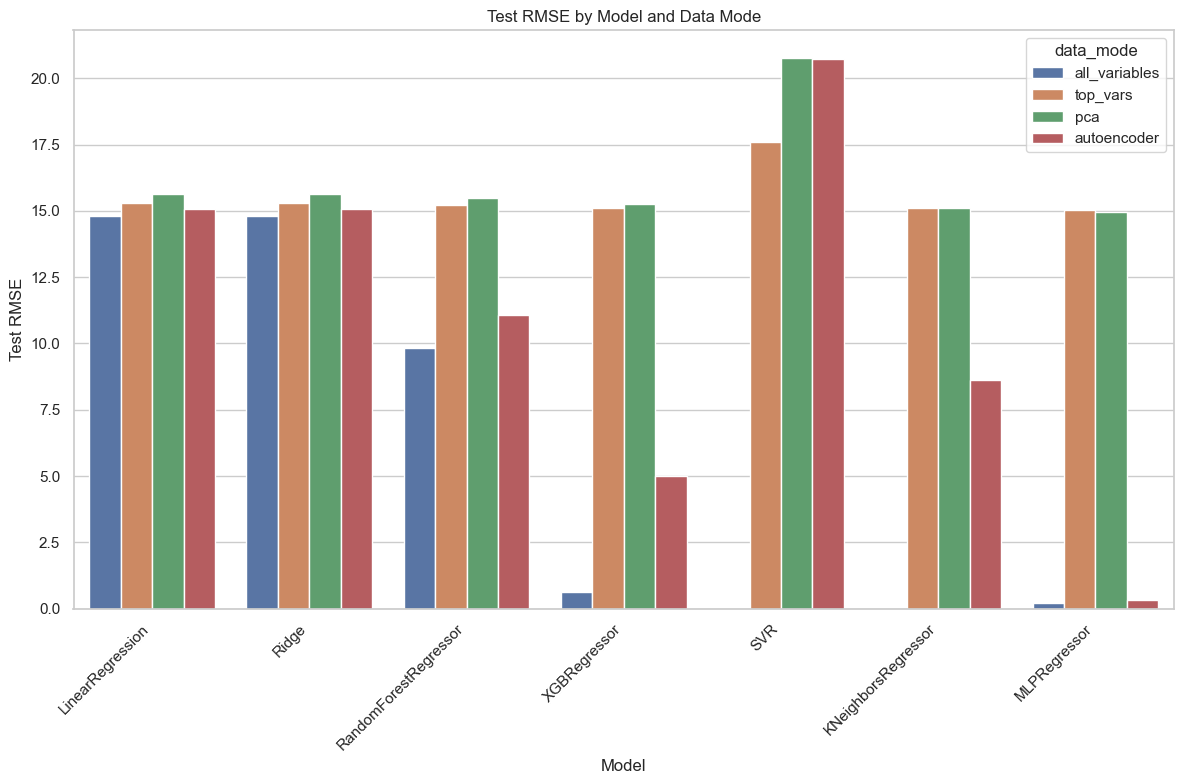

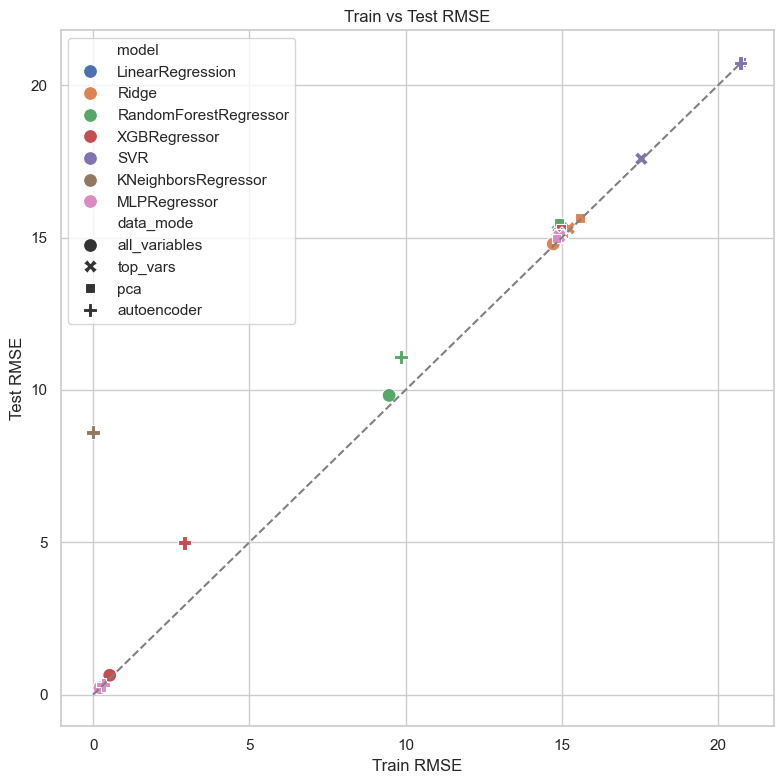

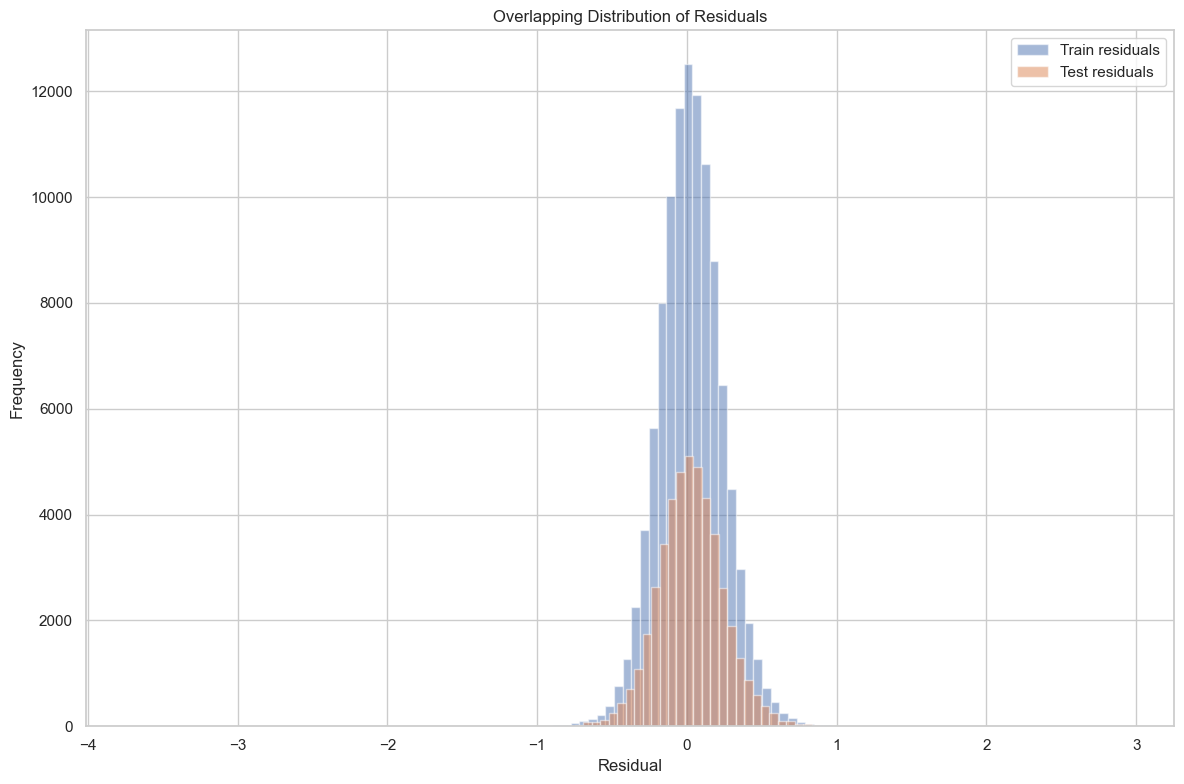

In [51]:
models_eval_selection("European_Vanilla")

In [53]:
best_model_info["model"]

'MLPRegressor'

In [40]:
models_logs[best_model_idx]

{'family': 'neural_networks',
 'model': 'MLPRegressor',
 'data_mode': 'all_variables',
 'time_s': 436.6651062965393,
 'gs_object': GridSearchCV(cv=3, estimator=MLPRegressor(max_iter=100, random_state=2025),
              n_jobs=-2,
              param_grid={'hidden_layer_sizes': [(100,), (50,),
                                                 (40, 40, 40, 40)],
                          'learning_rate': ['constant', 'adaptive']},
              scoring='neg_root_mean_squared_error', verbose=10)}

In [41]:
best_model_object = models_logs[best_model_idx].get("gs_object")
data = data_modes[models_logs[best_model_idx].get("data_mode")]

In [ ]:
data_modes_file_path = "../data/03_splitted/European_Vanilla/data_modes.pkl"
with open(data_modes_file_path, "rb") as f:
    data_modes = pickle.load(f)

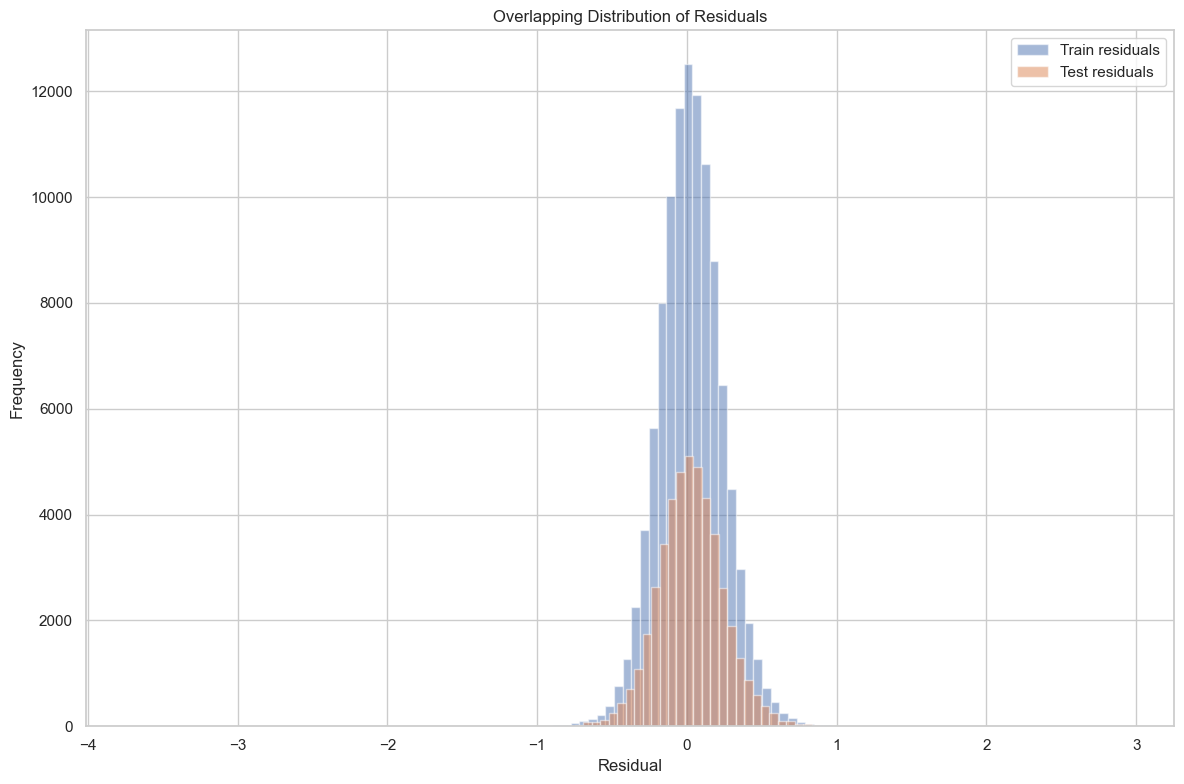